### Imports

In [138]:
from tracker import Tracker
import pickle as pkl
import cv2
import os
import numpy as np
import xml.etree.ElementTree as ET

### Tracking by Overlap

In [139]:
def newf_data(data):
    new_data = {}
    for i, (k, v) in enumerate(data.items()):
        new_data[i] = v
    return new_data

In [143]:
def process_video(video_path, annotations_path, detections_path, output_path, tracking_output, split_index, new_f=True, thr=0.5):
    if new_f:
        with open(detections_path, 'rb') as f:
            data = pkl.load(f)
            data = newf_data(data)
    else:
        with open(detections_path, 'rb') as f:
            data = pkl.load(f)
    
    cap = cv2.VideoCapture(video_path)
    width = int(cap.get(3))
    height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    tracker = Tracker(iou_threshold=thr)
    tracker.load_gt_annotations_xml(annotations_path, split_index)
    frame_idx = 0
    object_colors = {}

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if frame_idx < split_index:
            frame_idx += 1
            continue
        
        detections = data[frame_idx-split_index]
        
        tracker.update(detections, tracker.gt_detections[frame_idx-split_index])
        
        """if frame_idx == split_index+2:
            cv2.imwrite('frame2.png', frame2)
            frame3, object_colors = tracker.draw_tracks2(frame2, object_colors)
            cv2.imwrite('frame3.png', frame3)
        frame2, object_colors = tracker.draw_tracks2(frame, object_colors)"""
        
        frame, object_colors = tracker.draw_tracks2(frame, object_colors)
        
        
        out.write(frame)
        
        frame_idx += 1

    cap.release()
    out.release()
    cv2.destroyAllWindows()
    
    tracker.tracking_data["num_tracker_ids"] = tracker.next_id
    
    with open(tracking_output, 'wb') as f:
        pkl.dump(tracker.tracking_data, f)
        
    return 


In [142]:
video_path = '/Users/abriil/Uni/master/C6/Project1/data/AICity_data/train/S03/c010/vdo.avi'
annotations_path = '/Users/abriil/Uni/master/C6/Project1/data/ai_challenge_s03_c010-full_annotation.xml'
detections_path = '/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_A_wholevid.pkl'
output_path = 'output_video_switch.mp4'
tracking_output = 'tracking_outputs_switch.pkl'
split_index = 535

process_video(video_path=video_path, 
              annotations_path=annotations_path, 
              detections_path=detections_path, 
              output_path=output_path, 
              tracking_output=tracking_output, 
              split_index=split_index,
              new_f = True)

### Metric Extraction - HOTA, IDF1

In [53]:
from TrackEval.hota import HOTA
from TrackEval.identity import Identity

In [64]:
#Load tracking results
with open('/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_predsB_fold1.pkl', 'rb') as f:
        t_out = pkl.load(f)
        t_out['num_gt_ids'] = t_out['num_gt_ids'][0]

In [65]:
h = HOTA()
idf1 = Identity()


Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          


In [66]:
hota_metrics = h.eval_sequence(t_out)

In [67]:
idf1_metrics = idf1.eval_sequence(t_out)

In [68]:
hota_metrics

{'HOTA': array([0.46874176, 0.46727179, 0.46496159, 0.46206784, 0.45943865,
        0.45679633, 0.45446516, 0.4511052 , 0.44615874, 0.44399864,
        0.44242546, 0.44114251, 0.43894112, 0.43784379, 0.43573099,
        0.43203162, 0.42466477, 0.41280009, 0.34431163]),
 'DetA': array([0.84893959, 0.84373274, 0.83542216, 0.82508882, 0.81635206,
        0.80818802, 0.8006795 , 0.78890972, 0.77814464, 0.77031971,
        0.76535899, 0.76070449, 0.75376858, 0.74972489, 0.74214755,
        0.73005181, 0.70478914, 0.66094613, 0.43680881]),
 'AssA': array([0.25881563, 0.25878209, 0.25877848, 0.25876812, 0.25856965,
        0.25818606, 0.25795412, 0.25794574, 0.25581056, 0.25591295,
        0.25574965, 0.25582432, 0.25560803, 0.25570337, 0.25582715,
        0.25566859, 0.25587819, 0.25781816, 0.27140135]),
 'DetRe': array([0.93738918, 0.93427087, 0.92925711, 0.92295934, 0.91757872,
        0.91250382, 0.90779578, 0.90033629, 0.89342709, 0.88835219,
        0.88511159, 0.88205442, 0.87746866, 0

In [69]:
idf1_metrics

{'IDF1': 0.4340221623240491,
 'IDR': 0.4430449403852033,
 'IDP': 0.4253595538597006,
 'IDTP': 7246,
 'IDFN': 9109,
 'IDFP': 9789}

#### HOTA Metric Visualization

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [59]:
# Create time steps (assumed length based on data size)
timesteps = np.arange(len(hota_metrics['HOTA']))

# Set seaborn style
sns.set_style("darkgrid")

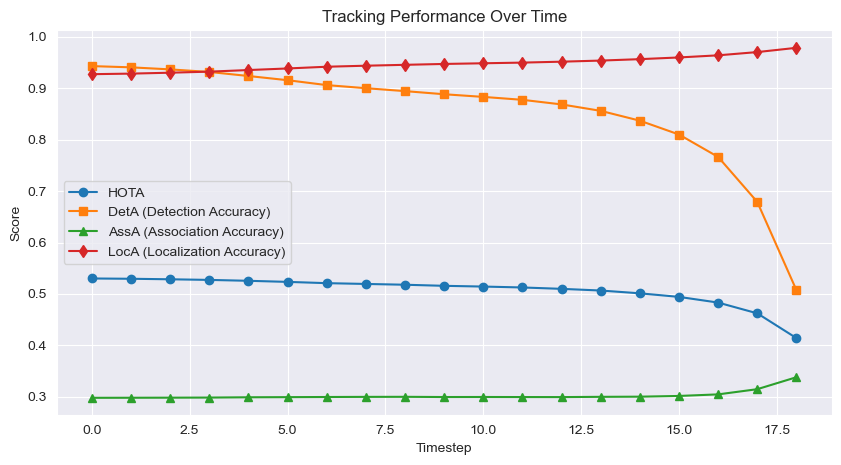

In [60]:
# --- Plot 1: HOTA, DetA, AssA, and LocA over time ---
plt.figure(figsize=(10, 5))
plt.plot(timesteps, hota_metrics['HOTA'], label='HOTA', marker='o')
plt.plot(timesteps, hota_metrics['DetA'], label='DetA (Detection Accuracy)', marker='s')
plt.plot(timesteps, hota_metrics['AssA'], label='AssA (Association Accuracy)', marker='^')
plt.plot(timesteps, hota_metrics['LocA'], label='LocA (Localization Accuracy)', marker='d')
plt.xlabel('Timestep')
plt.ylabel('Score')
plt.title('Tracking Performance Over Time')
plt.legend()
plt.show()

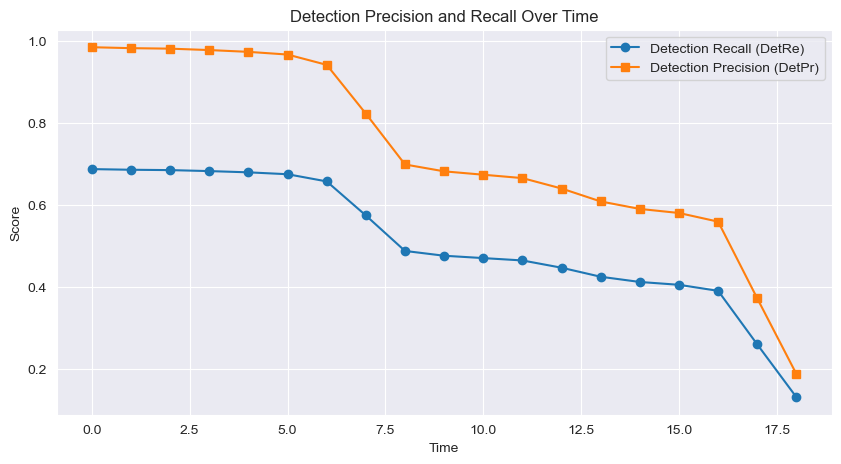

In [12]:
# --- Plot 2: Detection Precision vs. Recall over time ---
plt.figure(figsize=(10, 5))
plt.plot(timesteps, hota_metrics['DetRe'], label='Detection Recall (DetRe)', marker='o')
plt.plot(timesteps, hota_metrics['DetPr'], label='Detection Precision (DetPr)', marker='s')
plt.xlabel('Time')
plt.ylabel('Score')
plt.title('Detection Precision and Recall Over Time')
plt.legend()
plt.show()

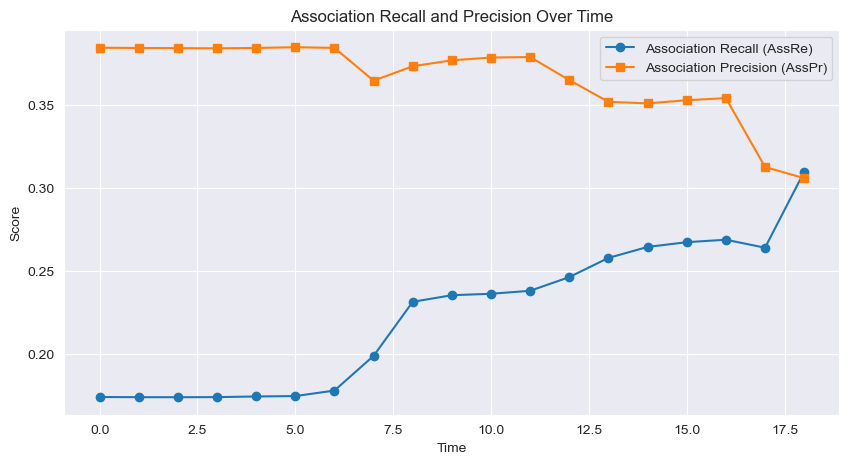

In [13]:
# --- Plot 3: Association Recall and Precision over time ---
plt.figure(figsize=(10, 5))
plt.plot(timesteps, hota_metrics['AssRe'], label='Association Recall (AssRe)', marker='o')
plt.plot(timesteps, hota_metrics['AssPr'], label='Association Precision (AssPr)', marker='s')
plt.xlabel('Time')
plt.ylabel('Score')
plt.title('Association Recall and Precision Over Time')
plt.legend()
plt.show()

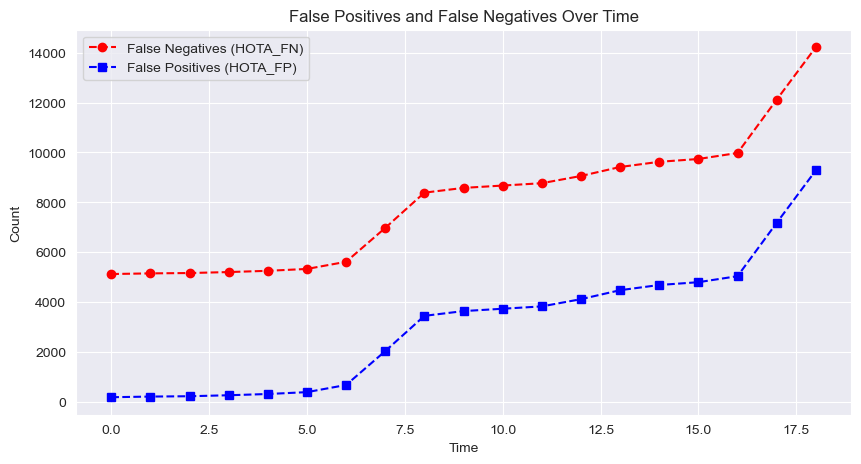

In [14]:
# --- Plot 4: False Positives and False Negatives ---
plt.figure(figsize=(10, 5))
plt.plot(timesteps, hota_metrics['HOTA_FN'], label='False Negatives (HOTA_FN)', marker='o', linestyle='--', color='r')
plt.plot(timesteps, hota_metrics['HOTA_FP'], label='False Positives (HOTA_FP)', marker='s', linestyle='--', color='b')
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('False Positives and False Negatives Over Time')
plt.legend()
plt.show()

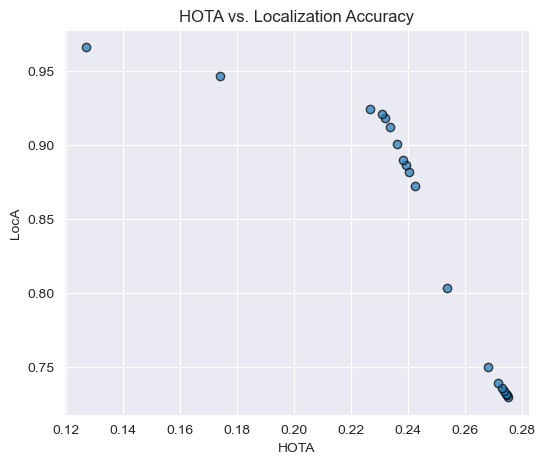

In [15]:
# --- Plot 5: HOTA vs. LocA (scatter plot to check correlation) ---
plt.figure(figsize=(6, 5))
plt.scatter(hota_metrics['HOTA'], hota_metrics['LocA'], alpha=0.7, edgecolors='k')
plt.xlabel('HOTA')
plt.ylabel('LocA')
plt.title('HOTA vs. Localization Accuracy')
plt.grid(True)
plt.show()

### Find best threshold

In [160]:
thresholds = [0.3]#, 0.3, 0.5, 0.7, 0.9]

video_path = '/Users/abriil/Uni/master/C6/Project1/data/AICity_data/train/S03/c010/vdo.avi'
annotations_path = '/Users/abriil/Uni/master/C6/Project1/data/ai_challenge_s03_c010-full_annotation.xml'
detections_path = "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_B_fold3_wholevid.pkl"
output_path = 'output_video_switch.mp4'
tracking_output = 'tracking_outputs_switch.pkl'
split_index = 0

for thr in thresholds:
    process_video(video_path=video_path, 
              annotations_path=annotations_path, 
              detections_path=detections_path, 
              output_path='tracking_outputs_'+str(thr)+".mp4", 
              tracking_output='tracking_outputs_'+str(thr)+".pkl", 
              split_index=split_index,
              new_f = True,
              thr=thr)

In [161]:
#Load tracking results
output_files = [
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_0.0.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_0.3.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_0.5.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_0.7.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_0.9.pkl"
]

thr_results = []
for i, output in enumerate(output_files):
    res = {}
    with open(output, 'rb') as f:
            t_out = pkl.load(f)
            t_out['num_gt_ids'] = t_out['num_gt_ids'][0]
    h = HOTA()
    idf1 = Identity()
    hota_metrics = h.eval_sequence(t_out)
    idf1_metrics = idf1.eval_sequence(t_out)
    res['filename'] = output.split('/')[-1][17:-4]
    res['HOTA(0)'] = hota_metrics['HOTA(0)']
    res['IDF1'] = idf1_metrics['IDF1']
    thr_results.append(res)


Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          


In [162]:
thr_results

[{'filename': '0.0',
  'HOTA(0)': 0.5290916726403682,
  'IDF1': 0.45789725699432243},
 {'filename': '0.3',
  'HOTA(0)': 0.5247239527225392,
  'IDF1': 0.45251613197437124},
 {'filename': '0.5',
  'HOTA(0)': 0.4741449199010123,
  'IDF1': 0.4160776842234651},
 {'filename': '0.7',
  'HOTA(0)': 0.47392715955431847,
  'IDF1': 0.4181672915002151},
 {'filename': '0.9',
  'HOTA(0)': 0.46866740297245746,
  'IDF1': 0.4004056296478397}]

### Results for different detections

In [95]:
detection_files = [
    "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_off-shelf_truck.pkl",
    "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_B_fold3_wholevid.pkl",
    "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_B_fold2_wholevid.pkl",
    "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_A_wholevid.pkl",
    "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/detections_whole_video/to_reformat/preds_pred_B_fold1_wholevid.pkl"
]

video_path = '/Users/abriil/Uni/master/C6/Project1/data/AICity_data/train/S03/c010/vdo.avi'
annotations_path = '/Users/abriil/Uni/master/C6/Project1/data/ai_challenge_s03_c010-full_annotation.xml'
output_path = 'output_video_switch.mp4'
tracking_output = 'tracking_outputs_switch.pkl'
split_index = 535

for detections_path in detection_files:
    process_video(video_path=video_path, 
              annotations_path=annotations_path, 
              detections_path=detections_path, 
              output_path='tracking_outputs_'+detections_path.split('/')[-1].split('.')[0]+".mp4", 
              tracking_output='tracking_outputs_'+detections_path.split('/')[-1].split('.')[0]+".pkl", 
              split_index=split_index,
              new_f = True)


In [99]:
#Load tracking results
output_files = [
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_preds_pred_A_wholevid.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_preds_pred_B_fold1_wholevid.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_preds_pred_B_fold2_wholevid.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_preds_pred_B_fold3_wholevid.pkl",
        "/Users/abriil/Uni/master/C6/Project1/mcv-c6-2025-team2/week2/tracking/tracking_outputs_preds_pred_off-shelf_truck.pkl"
]

map_scores = [0.966, 0.973, 0.966, 0.957, 0.503]
results = []
for i, output in enumerate(output_files):
    res = {}
    with open(output, 'rb') as f:
            t_out = pkl.load(f)
            t_out['num_gt_ids'] = t_out['num_gt_ids'][0]
    h = HOTA()
    idf1 = Identity()
    hota_metrics = h.eval_sequence(t_out)
    idf1_metrics = idf1.eval_sequence(t_out)
    res['filename'] = output.split('/')[-1][17:-4]
    res['mAP'] = map_scores[i]
    res['HOTA(0)'] = hota_metrics['HOTA(0)']
    res['IDF1'] = idf1_metrics['IDF1']
    results.append(res)


Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          

Identity Config:
THRESHOLD            : 0.5                           
PRINT_CONFIG         : True                          


### Visualizations for the slides

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Diccionario de mapeo para cambiar los filenames a nombres más descriptivos
filename_mapping = {
    "preds_pred_off-shelf_truck": "off-the-shelf",
    "preds_pred_A_wholevid": "Startegy A",
    "preds_pred_B_fold1_wholevid": "Startegy B fold 2",
    "preds_pred_B_fold2_wholevid": "Startegy B fold 3",
    "preds_pred_B_fold3_wholevid": "Startegy B fold 4"
}

# Diccionario de colores personalizados para cada métrica
color_mapping = {
    "HOTA(0)": "#98c6ca",  # Azul
    "IDF1": "#aae8ec"  # Naranja
}

# Definir el orden personalizado de los archivos en el eje X
custom_order = ["off-the-shelf", "Startegy A", "Startegy B fold 2", "Startegy B fold 3", "Startegy B fold 4"]

# Preparar los datos para el gráfico
data = []
for result in results:
    filename = result['filename']
    mAP = result['mAP']
    label = filename_mapping.get(filename, filename)
    hota = result['HOTA(0)']
    idf1 = result['IDF1']
    data.append({'filename': label, 'metric': 'HOTA(0)', 'value': hota, 'mAP': mAP})
    data.append({'filename': label, 'metric': 'IDF1', 'value': idf1, 'mAP': mAP})

# Convertir los datos en un DataFrame de pandas
df = pd.DataFrame(data)

# Ordenar los datos según el orden personalizado
df['filename'] = pd.Categorical(df['filename'], categories=custom_order, ordered=True)
df = df.sort_values('filename')

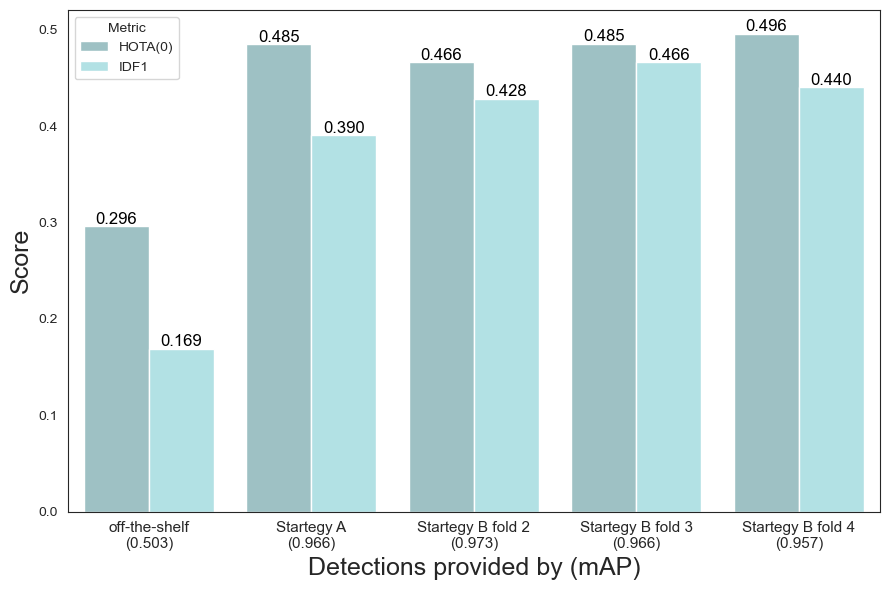

In [137]:
# Crear un barplot usando seaborn con colores personalizados
# Set seaborn style
sns.set_style("white")
plt.figure(figsize=(9, 6))
sns.barplot(x='filename', y='value', hue='metric', data=df, palette=color_mapping)

# Personalizar las etiquetas del eje X para incluir el valor de mAP con salto de línea
plt.xticks(ticks=range(len(df['filename'].unique())), 
           labels=[f"{f}\n({df[df['filename'] == f]['mAP'].iloc[0]:.3f})" for f in df['filename'].unique()],
           rotation=0, ha='center', fontsize=11)

# Añadir los valores de HOTA(0) e IDF1 encima de cada barra solo si son mayores a cero
for p in plt.gca().patches:
    value = p.get_height()
    if value > 0:
        plt.gca().annotate(f'{value:.3f}', 
                           (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha='center', va='center', 
                           fontsize=12, color='black', 
                           xytext=(0, 5), textcoords='offset points')

# Títulos y etiquetas
plt.xlabel('Detections provided by (mAP)', fontsize=18)
plt.ylabel('Score', fontsize=18)
plt.legend(title='Metric')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

In [ ]:
import cv2
import numpy as np
from PIL import Image

def video_to_gif(video_path, output_path="output.gif", duration=100, loop=0, scale=1.0):
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # Fin del video

        # Convertir a RGB (cv2 usa BGR por defecto)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Downsample de la imagen si scale es menor a 1.0
        if scale != 1.0:
            new_width = int(frame.shape[1] * scale)
            new_height = int(frame.shape[0] * scale)
            frame = cv2.resize(frame, (new_width, new_height))

        frames.append(Image.fromarray(frame))

    cap.release()  # Liberar el video

    if frames:
        frames[0].save(output_path, save_all=True, append_images=frames[1:], duration=duration, loop=loop)
        print(f"GIF saved at {output_path}")
    else:
        print("Error: No frames extracted from video.")

# Ejemplo de uso:
video_path = '/Users/arnaubarrera/Desktop/MSc Computer Vision/C6. Video Analysis/mcv-c6-2025-team2/bycicle.mp4'
video_to_gif(video_path, "output.gif", duration=100, loop=0, scale=0.4)